#### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
from sklearn.utils import shuffle
import math
import sklearn

#### Data preprocessing and mixing

In [4]:
"""
Load Data
"""
X_sig_path = "training_data/X_sig.npy"
y_sig_path = "training_data/y_sig.npy"
X_sb_path = "training_data/X_sb.npy"
y_sb_path = "training_data/y_sb.npy"
X_bgsig_path = "training_data/X_bgsig.npy"
y_bgsig_path = "training_data/y_bgsig.npy"
X_sig = np.load(X_sig_path)
y_sig = np.load(y_sig_path)
X_sb = np.load(X_sb_path)
y_sb = np.load(y_sb_path)
X_bgsig = np.load(X_bgsig_path)
y_bgsig = np.load(y_bgsig_path)

In [31]:
sig_nonzeros = np.count_nonzero(np.sum(X_sig,axis=2),axis=1)
sb_nonzeros = np.count_nonzero(np.sum(X_sb,axis=2),axis=1)
bgsig_nonzeros = np.count_nonzero(np.sum(X_bgsig,axis=2),axis=1)

In [32]:
print(min(sig_nonzeros))
print(min(sb_nonzeros))
print(min(bgsig_nonzeros))

36
14
14


In [17]:
X_sig[:,:,:3]

array([[[ 1.26945e+00, -3.34614e-01,  9.72006e-01],
        [ 3.86484e-01, -3.06462e-01,  6.43719e-01],
        [ 1.89127e+00, -2.83125e-01,  8.97308e-01],
        ...,
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00]],

       [[ 1.53836e+02, -1.70761e+00,  2.20815e+00],
        [ 7.97745e-01,  1.69359e-01, -4.55910e-01],
        [ 5.36531e+00,  2.08073e-01, -6.85767e-01],
        ...,
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00]],

       [[ 1.22140e+02, -1.94521e+00,  1.46355e+00],
        [ 5.85577e-01, -1.08852e-01,  2.20590e+00],
        [ 2.61609e+00, -2.18327e-02, -2.68673e+00],
        ...,
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00]],

       ...,

      

In [42]:
a = np.array( [[ 4.11999e-01, -2.03658e+00, -1.34492e+00],
        [ 1.39746e+00, -2.01764e+00, -1.13743e+00],
        [ 9.42349e-01, -2.00110e+00, -1.08067e+00]])

In [44]:
np.sum(a)

-6.866531999999999

In [48]:
def prep_and_shufflesplit_data(anomaly_ratio, size_each = 76000, shuffle_seed = 69,
                               train = 0.8, val = 0.2, test_size_each = 5000, special_test = True, use_pid = True, limit_particles = 9999, normalize_all = False):
    
    """
    Pre-Data Selection
    """
        
    #how much bg and signal data to take?
    
    anom_size = round(anomaly_ratio * size_each)
    bgsig_size = size_each - anom_size
    
    # make sure we have enough data.
    assert (size_each <= X_sb.shape[0])
    assert (anom_size + test_size_each <= X_sig.shape[0])
    assert (bgsig_size + test_size_each <= X_bgsig.shape[0])
    
    """
    Data Selection
    """
    
    # select sideband datapoints
    this_X_sb = X_sb[:size_each]
    this_y_sb = np.zeros(size_each)
    
    # select bgsig datapoints
    this_X_bgsig = X_bgsig[:bgsig_size]
    this_y_bgsig = np.ones(bgsig_size)
    
    # select anomaly datapoints
    this_X_sig = X_sig[:anom_size]
    this_y_sig = np.ones(anom_size)
    
    """
    Shuffle + Train-Val-Test Split (not test set)
    """
    # Combine all 3 data sets
    this_X = np.concatenate([this_X_sb, this_X_bgsig, this_X_sig])
    this_y = np.concatenate([this_y_sb, this_y_bgsig, this_y_sig])
    
    # Shuffle before we split
    this_X, this_y = shuffle(this_X, this_y, random_state = shuffle_seed)
    
    
    (this_X_tr, this_X_v, _,
     this_y_tr, this_y_v, _) = data_split(this_X, this_y, val=val, test=0)
        
    
    print('Size of sb:')
    print(this_X_sb.shape)
    print('Size of bgsig:')
    print(this_X_bgsig.shape)
    print('Size of sig:')
    print(this_X_sig.shape)
        
    
    """
    Get the test set
    """
    
    # select the data
    this_X_test_P = X_sig[anom_size:anom_size+test_size_each]
    this_X_test_N = X_bgsig[bgsig_size:bgsig_size+test_size_each]
    
    this_y_test_P = np.ones(test_size_each)
    this_y_test_N = np.zeros(test_size_each)
        
    # Shuffle the combination    
    this_X_te = np.concatenate([this_X_test_P, this_X_test_N])
    this_y_te = np.concatenate([this_y_test_P, this_y_test_N])
    
    this_X_te, this_y_te = shuffle(this_X_te, this_y_te, random_state = shuffle_seed)
#     print('Size of test set:')
#     print(this_X_te.shape)
#     print('Test set distribution:')
#     print(np.unique(this_y_te,return_counts = True))
    
    
    X_train, X_val, X_test, y_train, y_val, y_test \
    = this_X_tr, this_X_v, this_X_te, this_y_tr, this_y_v, this_y_te
    
    """
    Data processing
    """
    
    # chop off 
    
    if limit_particles < X_train.shape[1]:
        print('CHOPPED!!!')
        X_train = X_train[:,:limit_particles,:]
        X_val = X_val[:,:limit_particles,:]
        X_test = X_test[:,:limit_particles,:]
    
    # Centre and normalize all the Xs
    for x in X_train:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    for x in X_val:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    for x in X_test:
        mask = x[:,0] > 0
        yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()
        if normalize_all:
            x /= np.sum(x)
        
    
    if use_pid:
        # remap PIDs for all the Xs
        remap_pids(X_train, pid_i=3)
        remap_pids(X_val, pid_i=3)
        remap_pids(X_test, pid_i=3)
    else:
        X_train = X_train[:,:,:3]
        X_val = X_val[:,:,:3]
        X_test = X_test[:,:,:3]
    
    # change Y to categorical Matrix
    Y_train = to_categorical(y_train, num_classes=2)
    Y_val = to_categorical(y_val, num_classes=2)
    Y_test = to_categorical(y_test, num_classes=2)
    
    print('Training set size, distribution:')
    print(X_train.shape)
    print(np.unique(y_train,return_counts = True))
    print('Validations set size, distribution:')
    print(X_val.shape)
    print(np.unique(y_val,return_counts = True))
    print('Test set size, distribution:')
    print(X_test.shape)
    print(np.unique(y_test,return_counts = True))
    
    return X_train, X_val, X_test, Y_train,Y_val,Y_test

#### Model definition

In [24]:
Phi_sizes, F_sizes = (20, 20, 20), (20,20,20)
num_epoch = 3
num_cycles = 3
batch_size = 100

In [6]:
def train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test):
    model = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
    histories = []
    Y_predicts = []
    for cycle in range(num_cycles):
        print('----')
        print('Beginning cycle ' + str(cycle))
        history = model.fit(X_train, Y_train,
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_val, Y_val),
              verbose=1)
        Y_predict = model.predict(X_test)
        histories.append(history)
        Y_predicts.append(Y_predict)
    
    return (histories, Y_test, Y_predicts, model)

In [7]:
def evaluate_model(histories, Y_test, Y_predicts):
    fine_index = list(range(num_epoch * num_cycles))
    rough_index = list(range(num_epoch - 1, num_epoch * num_cycles, num_epoch))
    train_acc = []
    val_acc = []
    for h in histories:
        curr_train_acc = h.history['acc']
        curr_val_acc = h.history['val_acc']
        train_acc.extend(curr_train_acc)
        val_acc.extend(curr_val_acc)


    medians = []
    test_acc = []
    for Y_pred in Y_predicts:
        medians.append(np.median(Y_pred[:,1:]))
        curr_acc = accuracy_score(Y_test[:,1:], (Y_pred[:,1:]*2).astype(int))
        test_acc.append(curr_acc)

    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fine_index, train_acc, label = 'train_acc', color='tab:blue')
    ax.plot(fine_index, val_acc, label = 'val_acc', color='tab:orange')
    #ax.plot(rough_index, medians, marker = '.', label = 'median', color = 'green')
    ax.plot(rough_index, test_acc, marker = '.',linestyle = ':',label = 'test_acc', color = 'red')
    ax.legend()
    ax.set_xlim([0, num_epoch * num_cycles])

    ax.set_title('line plot with data points')

    # display the plot
    plt.show()

In [8]:
def final_evaluation(Y_test, Y_predicts):
    Y_predict = Y_predicts[-1]
    roc_curve = sklearn.metrics.roc_curve(Y_test[:,1:], Y_predict[:,1:])
    plt.plot(roc_curve[0],roc_curve[1])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.show()

### Execution

#### Attempt 1: 25 percent signal.

Uses standard data processing params

In [67]:
Phi_sizes, F_sizes = (40, 20, 12), (40,20)
num_epoch = 3
num_cycles = 15
batch_size = 20

In [68]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.25)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(57000, 282, 4)
Size of sig:
(19000, 282, 4)
Training set size, distribution:
(121600, 282, 4)
(array([0., 1.]), array([60746, 60854]))
Validations set size, distribution:
(30400, 282, 4)
(array([0., 1.]), array([15254, 15146]))
Test set size, distribution:
(10000, 282, 4)
(array([0., 1.]), array([5000, 5000]))


In [69]:
histories, Y_test, Y_predicts, model = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     200         input[0][0]                      
__________________________________________________________________________________________________
activation_29 (Activation)      (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_29[0][0]              
__________________________________________________________________________________________________
activation

Epoch 2/3
121600/121600 [==============================] - 41s 335us/step - loss: 0.3894 - acc: 0.8157 - val_loss: 0.3759 - val_acc: 0.8292
Epoch 3/3
121600/121600 [==============================] - 41s 340us/step - loss: 0.3870 - acc: 0.8171 - val_loss: 0.3831 - val_acc: 0.8222
----
Beginning cycle 10
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 41s 340us/step - loss: 0.3825 - acc: 0.8198 - val_loss: 0.4071 - val_acc: 0.8075
Epoch 2/3
121600/121600 [==============================] - 41s 339us/step - loss: 0.3791 - acc: 0.8225 - val_loss: 0.3911 - val_acc: 0.8156
Epoch 3/3
121600/121600 [==============================] - 42s 341us/step - loss: 0.3750 - acc: 0.8246 - val_loss: 0.3702 - val_acc: 0.8315
----
Beginning cycle 11
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 42s 343us/step - loss: 0.3736 - acc: 0.8253 - val_loss: 0.3735 - val_acc: 0.8289
Epoch 2/3


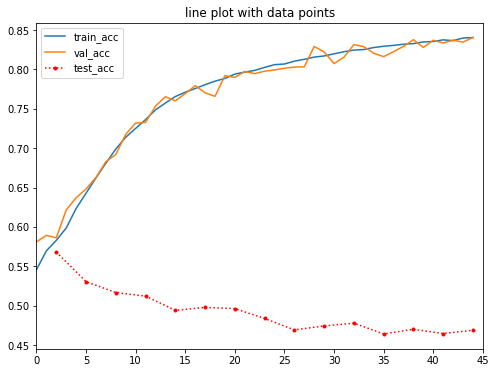

In [70]:
evaluate_model(histories, Y_test, Y_predicts)

#### Attempt 2: 5 percent signal

In [71]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.05)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(72200, 282, 4)
Size of sig:
(3800, 282, 4)
Training set size, distribution:
(121600, 282, 4)
(array([0., 1.]), array([60825, 60775]))
Validations set size, distribution:
(30400, 282, 4)
(array([0., 1.]), array([15175, 15225]))
Test set size, distribution:
(10000, 282, 4)
(array([0., 1.]), array([5000, 5000]))


In [72]:
histories, Y_test, Y_predicts, model = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     200         input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_35[0][0]              
__________________________________________________________________________________________________
activation

Epoch 2/3
121600/121600 [==============================] - 41s 340us/step - loss: 0.5502 - acc: 0.7085 - val_loss: 0.5618 - val_acc: 0.7006
Epoch 3/3
121600/121600 [==============================] - 42s 341us/step - loss: 0.5476 - acc: 0.7105 - val_loss: 0.5562 - val_acc: 0.7037
----
Beginning cycle 10
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 41s 341us/step - loss: 0.5455 - acc: 0.7121 - val_loss: 0.5586 - val_acc: 0.7001
Epoch 2/3
121600/121600 [==============================] - 42s 343us/step - loss: 0.5442 - acc: 0.7130 - val_loss: 0.5434 - val_acc: 0.7166
Epoch 3/3
121600/121600 [==============================] - 42s 343us/step - loss: 0.5427 - acc: 0.7141 - val_loss: 0.5472 - val_acc: 0.7118
----
Beginning cycle 11
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 42s 343us/step - loss: 0.5396 - acc: 0.7157 - val_loss: 0.5469 - val_acc: 0.7092
Epoch 2/3


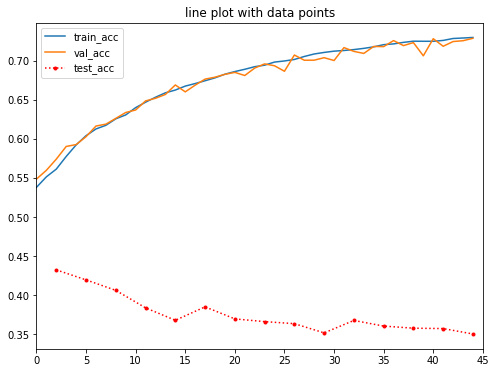

In [73]:
evaluate_model(histories, Y_test, Y_predicts)

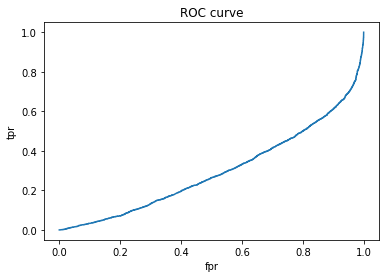

In [76]:
final_evaluation(Y_test, Y_predicts)

#### Attempt 3: 0% signal

In [49]:
Phi_sizes, F_sizes = (40, 20, 12), (40,20)
num_epoch = 3
num_cycles = 3
batch_size = 20

In [50]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0,use_pid = False)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(76000, 282, 4)
Size of sig:
(0, 282, 4)
Training set size, distribution:
(121600, 282, 3)
(array([0., 1.]), array([60685, 60915]))
Validations set size, distribution:
(30400, 282, 3)
(array([0., 1.]), array([15315, 15085]))
Test set size, distribution:
(10000, 282, 3)
(array([0., 1.]), array([5000, 5000]))


In [51]:
histories_3, Y_test_3, Y_predicts_3, model_3 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     160         input[0][0]                      
__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_19[0][0]              
__________________________________________________________________________________________________
activation

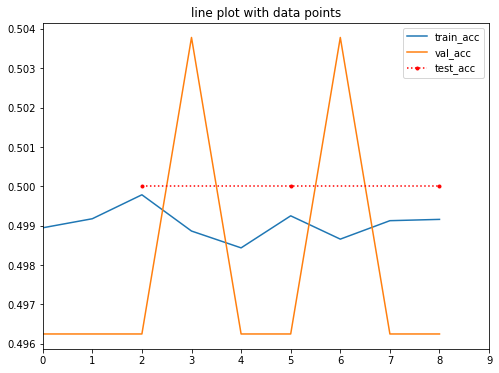

In [52]:
evaluate_model(histories_3, Y_test_3, Y_predicts_3)

#### Attempt 4: negligible signal (5/76000)

In [86]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(6.6e-5)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(75995, 282, 4)
Size of sig:
(5, 282, 4)
Training set size, distribution:
(121600, 282, 4)
(array([0., 1.]), array([60812, 60788]))
Validations set size, distribution:
(30400, 282, 4)
(array([0., 1.]), array([15188, 15212]))
Test set size, distribution:
(10000, 282, 4)
(array([0., 1.]), array([5000, 5000]))


In [87]:
histories_4, Y_test_4, Y_predicts_4, model_4 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     200         input[0][0]                      
__________________________________________________________________________________________________
activation_53 (Activation)      (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_53[0][0]              
__________________________________________________________________________________________________
activation

Epoch 2/3
121600/121600 [==============================] - 43s 350us/step - loss: 0.5534 - acc: 0.6876 - val_loss: 0.5578 - val_acc: 0.6804
Epoch 3/3
121600/121600 [==============================] - 43s 355us/step - loss: 0.5528 - acc: 0.6887 - val_loss: 0.5528 - val_acc: 0.6886
----
Beginning cycle 10
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 43s 355us/step - loss: 0.5501 - acc: 0.6906 - val_loss: 0.5595 - val_acc: 0.6858
Epoch 2/3
121600/121600 [==============================] - 43s 352us/step - loss: 0.5484 - acc: 0.6917 - val_loss: 0.5793 - val_acc: 0.6710
Epoch 3/3
121600/121600 [==============================] - 43s 350us/step - loss: 0.5468 - acc: 0.6925 - val_loss: 0.5470 - val_acc: 0.6902
----
Beginning cycle 11
Train on 121600 samples, validate on 30400 samples
Epoch 1/3
121600/121600 [==============================] - 43s 351us/step - loss: 0.5445 - acc: 0.6930 - val_loss: 0.5529 - val_acc: 0.6897
Epoch 2/3


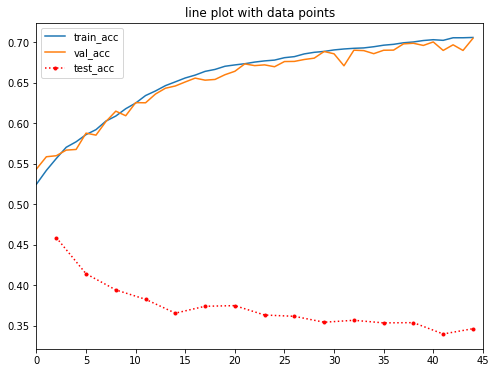

In [88]:
evaluate_model(histories_4, Y_test_4, Y_predicts_4)

#### Attempt 5: 90 signal

In [54]:
X_train, X_val, X_test, Y_train,Y_val,Y_test = prep_and_shufflesplit_data(0.9, use_pid = False)

Size of sb:
(76000, 282, 4)
Size of bgsig:
(7600, 282, 4)
Size of sig:
(68400, 282, 4)
Training set size, distribution:
(121600, 282, 3)
(array([0., 1.]), array([60741, 60859]))
Validations set size, distribution:
(30400, 282, 3)
(array([0., 1.]), array([15259, 15141]))
Test set size, distribution:
(10000, 282, 3)
(array([0., 1.]), array([5000, 5000]))


In [55]:
histories_5, Y_test_5, Y_predicts_5, model_5 = train_model(X_train, X_val, X_test, Y_train,Y_val,Y_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 40)     160         input[0][0]                      
__________________________________________________________________________________________________
activation_25 (Activation)      (None, None, 40)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 20)     820         activation_25[0][0]              
__________________________________________________________________________________________________
activation

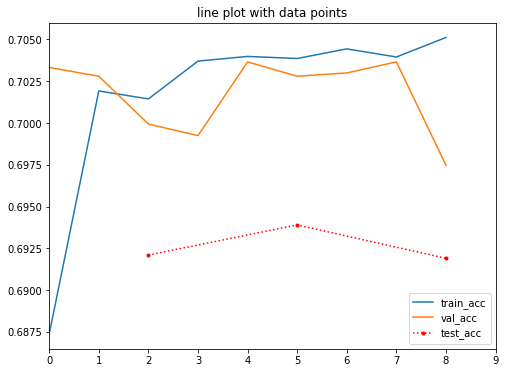

In [56]:
evaluate_model(histories_5, Y_test_5, Y_predicts_5)